# Automatic detection of malaria from erythrocytes: Optimization of a deep learning CNN model:  Part II - Model Development

Julia A. Moffitt, PhD

In part I of this project The EDA was performed. In Part II - several models are expolored and developed.  The most robust model, a basic CNN was used to attain 99% accuracy, 99% recall and 99% precion in visual detection of malaria from RBCs with only 16 false negatives identified from among the 5233 test images.  


###<b> Mounting the Drive

In [4]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


###<b>Loading libraries</b>

In [88]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D, LayerNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Loading the data set</b>

**Note:** 
- A total of 24,958 train and 2,600 test images (colored) that were taken from microscopic images.

Prior to initiating the project a literature search on PubMed was conducted. Within that search an article by Fuhad et. al. 2020 took the above data set and cleaned and correctly labeled it with the assistance of an expert (2). Some ambigouous images were removed and others had labels corrected. This resulted in 13,029 uninfected and 13,132 parasitized images.

It is the goal of this project to use the correctly labeled and updated data set in the development of the model. Corrected Malaria Data—Google Drive. [(accessed on 29 December 2019)];2019 Available online: https://drive.google.com/drive/folders/10TXXa6B_D4AKuBV085tX7UudH1hINBRJ?usp=sharing.

These images are of the following categories:

Parasitized: The parasitized cells contain the Plasmodium parasite which causes malaria
Uninfected: The uninfected cells are free of the Plasmodium parasites

In [89]:
#Load True Parasatized Data Set from the Google drive
path = '/content/drive/MyDrive/Updated_Cell_Images/True_parasitized-20211229T200549Z-001.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [90]:
#Load True Uninfected Data Set from the Google drive
path = '/content/drive/MyDrive/Updated_Cell_Images/True_uninfected-20211229T205351Z-001.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [91]:
#importing additional libraries that will be needed for image processing
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils

In [92]:
parasitized_data = os.listdir('/content/True_parasitized')
print(parasitized_data[:10]) #the output we get are the .png files

uninfected_data = os.listdir('/content/True_uninfected')
print('\n')
print(uninfected_data[:10])

['C76P37ThinF_IMG_20150815_172902_cell_222.png', 'C129P90ThinF_IMG_20151004_133244_cell_116.png', 'C60P21thinF_IMG_20150804_105034_cell_114.png', 'C179P140ThinF_IMG_20151127_153420_cell_175.png', 'C39P4thinF_original_IMG_20150622_111942_cell_5.png', 'C120P81ThinF_IMG_20151002_125443_cell_136.png', 'C88P49ThinF_IMG_20150820_150141_cell_218.png', 'C80P41ThinF_IMG_20150817_111802_cell_16.png', 'C68P29N_ThinF_IMG_20150819_134830_cell_11.png', 'C99P60ThinF_IMG_20150918_142334_cell_5.png']


['C228ThinF_IMG_20151112_142216_cell_183.png', 'C237ThinF_IMG_20151127_104954_cell_162.png', 'C89P50ThinF_IMG_20150820_163728_cell_139.png', 'C4thin_original_IMG_20150608_170038_cell_96.png', 'C79P40ThinF_IMG_20150817_103901_cell_54.png', 'C152P113ThinF_IMG_20151115_124032_cell_103.png', 'C216ThinF_IMG_20151106_135653_cell_75.png', 'C56P17thinF_IMG_20150728_160438_cell_22.png', 'C108P69ThinF_IMG_20150924_225004_cell_45.png', 'C86P47ThinF_IMG_20150820_124025_cell_83.png']


Visualizing PARASITIZED and UNINFECTED images from each folder. 

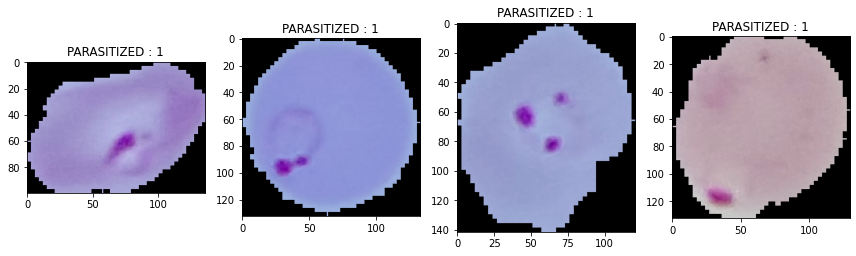

In [10]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread('/content/True_parasitized' + "/" + parasitized_data[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

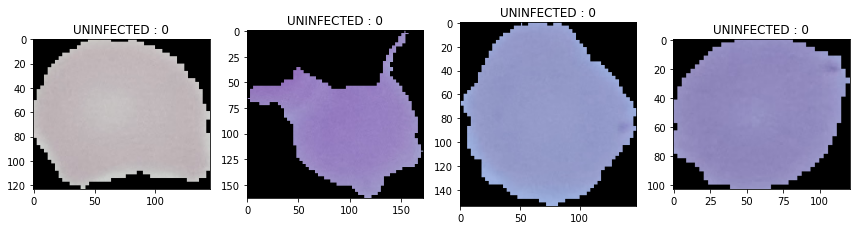

In [11]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread('/content/True_uninfected' + "/" + uninfected_data[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

Creating lists for data and lables and standardizing images for all four folders into 64x64 size. 

In [93]:
data = []
labels = []
for img in parasitized_data:
    try:
        img_read = plt.imread('/content/True_parasitized' + "/" + img)
        img_resize = cv2.resize(img_read, (64, 64))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None
        
for img in uninfected_data:
    try:
        img_read = plt.imread('/content/True_uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (64, 64))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

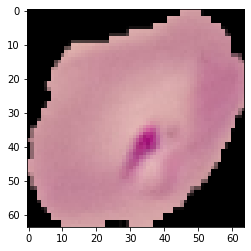

In [94]:
plt.imshow(data[0])
plt.show()

In [95]:
image_data = np.array(data)
labels = np.array(labels)

In [96]:
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

Creating Training and Test data sets at an 80:20 split.

In [97]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.2, random_state = 101)

###<b>Normalize the images

In [98]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
x_train = (x_train/255).astype('float32')
x_test = (x_test/255).astype('float32')

**One hot encoding the data.**

In [99]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

In [100]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {x_test.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (20928, 64, 64, 3)
SHAPE OF TESTING IMAGE DATA : (5233, 64, 64, 3)
SHAPE OF TRAINING LABELS : (20928, 2)
SHAPE OF TESTING LABELS : (5233, 2)


As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

####<b> Importing the required libraries

In [101]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [102]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

# **Model 1:  ReLU activation function, categorical cross entropy loss, softmax output.**  

* Starting with a simple initial CNN model and some popular configurations including ReLU activation function in hidden layers, categorical cross entropy loss function and softmax activation function on the final output layer.  
* Keeping dropout layers and rates standard to prevent overfitting.

####<b> Building the Model

In [ ]:
def CNNbuild1(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model


In [ ]:
#instantiate model
height = 64
width = 64
classes = 2
channels = 3
model = CNNbuild1(height = height, width = width, classes = classes, channels = channels)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

####<b>Compiling the model

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> Using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
524/524 [==============================] - 11s 13ms/step - loss: 0.6933 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 2/20
524/524 [==============================] - 6s 12ms/step - loss: 0.6933 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4986
Epoch 3/20
524/524 [==============================] - 6s 12ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 4/20
524/524 [==============================] - 6s 12ms/step - loss: 0.6933 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 5/20
524/524 [==============================] - 6s 12ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4986
Epoch 6/20
524/524 [==============================] - 6s 12ms/step - loss: 0.6933 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.4986


####<b>Evaluating the model

<b>Plotting the train and validation accuracy

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

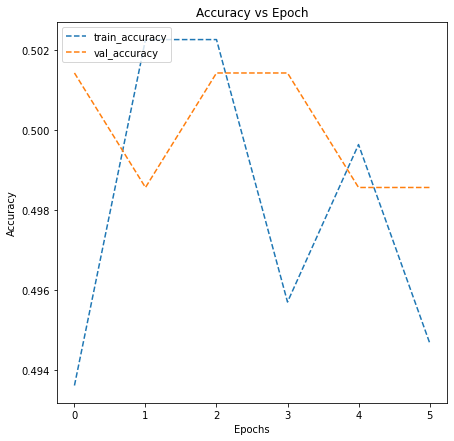

In [ ]:
plot_accuracy(history)

In [ ]:
# Evaluate the model against test data to calculate the accuracy
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

164/164 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5043

 Test_Accuracy:- 0.5042996406555176


<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2594
           1       0.50      1.00      0.67      2639

    accuracy                           0.50      5233
   macro avg       0.25      0.50      0.34      5233
weighted avg       0.25      0.50      0.34      5233



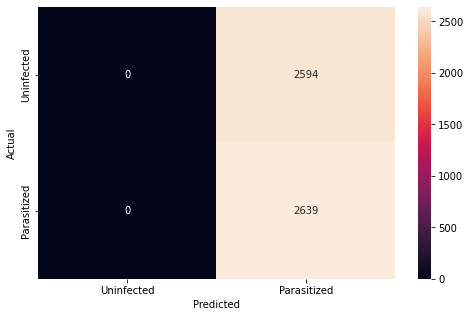

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Model 1 Observations and insights:** 

* At first observation, it looks as though there were no uninfected data included in the data set.  However, it was varified that there are data in both sets within the training and test set.  

* The model did not fit and stopped after only 6 minutes and 4 epochs.  

* After doing some research the model appears to be stuck in a "dead neuron" and not advancing.  We will try the LeakyReLU threshold.  Since this function allows for small values other than zero (i.e. 0.001, the alpha), due to the negtaive slope protion of the function, it may prevent "dead end learning", and allow the learning to advance to the next hidden layer. 

* In the next model I will only change the activation function from ReLU to LeakyReLU, to isolate this variable in the model to determine it's effect on the ability of the model to learn.  

# **Model 2: LeakyReLU & Categorical Cross Entropy Loss, Softmax output**

Using an identical model to Model 1 with the only change in using LeakyReLU activation function in hidden layers.  

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.layers import LeakyReLU

In [ ]:
def CNNbuild2(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'LeakyReLU', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'LeakyReLU'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'LeakyReLU'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [ ]:
#instantiate the model
height = 64
width = 64
classes = 2
channels = 3
model2 = CNNbuild2(height = height, width = width, classes = classes, channels = channels)
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

In [ ]:
#compile the model
model2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history2=model2.fit(x_train,y_train,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
524/524 [==============================] - 8s 13ms/step - loss: 0.6940 - accuracy: 0.4937 - val_loss: 0.6936 - val_accuracy: 0.4986
Epoch 2/20
524/524 [==============================] - 6s 12ms/step - loss: 0.6943 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 3/20
524/524 [==============================] - 7s 13ms/step - loss: 0.6944 - accuracy: 0.5033 - val_loss: 0.6944 - val_accuracy: 0.5014
Epoch 4/20
524/524 [==============================] - 7s 13ms/step - loss: 0.6933 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.5014
Epoch 5/20
524/524 [==============================] - 7s 13ms/step - loss: 0.6867 - accuracy: 0.5415 - val_loss: 0.7088 - val_accuracy: 0.5076
Epoch 6/20
524/524 [==============================] - 6s 12ms/step - loss: 0.6126 - accuracy: 0.6577 - val_loss: 0.5766 - val_accuracy: 0.6732
Epoch 7/20
524/524 [==============================] - 7s 14ms/step - loss: 0.4651 - accuracy: 0.7763 - val_loss: 0.4479 - val_accuracy: 0.7769

<b>Plotting the train and validation curves

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history2):
    N = len(history2.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history2.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history2.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

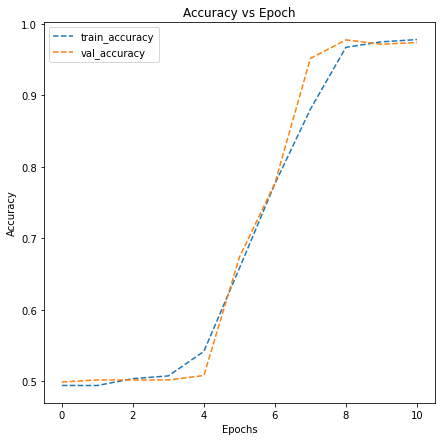

In [ ]:
plot_accuracy(history2)

<b> Plotting the confusion matrix

In [ ]:
accuracy = model2.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

164/164 [==============================] - 1s 7ms/step - loss: 0.1017 - accuracy: 0.9694

 Test_Accuracy:- 0.9694247841835022


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2594
           1       1.00      0.94      0.97      2639

    accuracy                           0.97      5233
   macro avg       0.97      0.97      0.97      5233
weighted avg       0.97      0.97      0.97      5233



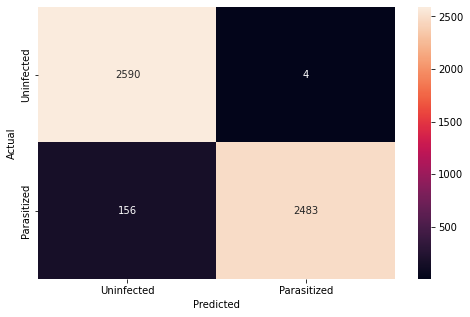

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model2.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Model 2 Observations and Insights:**



* Here we can clearly observe that the model finally did learn and advance once it was able to get past the "dead neuron".  

* Since the only variable we changed here was the activation function from ReLU to LeakyReLU, we can concluide that in this situation, the slightly negatie slope of LeakyReLU allowed the model to learn and advance through all the hidden layers.  

* The result of this model was actually quite good, as there was an overall accuracy of 97%, however the recall was 94% for parasitized (which is indicative of false negatives) - thus since this is a medical diagnostic screening model, we would like to have as few false negatives as possible and would like to see our recall/sensitivity increase.  

* It took a long time to run this model (27 minutes), therefore may be computationaly more expensive than necessary.  Using Batch Normalization and returning to ReLU, which is computationally more simple when used in hidden layers, may help with this.  

* Also since the classification at the end is binary we will also try "binary crossentropy" for the loss function.  

* In addition, we will try to use the Sigmoid function as the final classification output function, since may best perform when used in the output layer for binary classification problems raning 0 to 1, as we have in this problem,, and may help improve the performance of the model.  

# **Model 3: ReLU, BatchNormalization, Binary crossentropy loss, Softmax output function**
  * ReLU: To make deep layers learn quicker.
  * Batch Normalization: To allow each layer to be standarized and learn independently, which should help learn faster.  
  * Binary cross entropy loss - since this is a binary classificaition, should be a better loss function for the problem at hand.

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from keras.regularizers import l2
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
def CNNbuild3(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5)) 
    model.add(Dense(classes, activation = 'softmax'))
    
    return model


    

In [ ]:
#instantiate the model
height = 64
width = 64
classes = 2
channels = 3
model3 = CNNbuild3(height = height, width = width, classes = classes, channels = channels)
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0

In [ ]:
#compile the model
#tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name="SGD")
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#using callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history3=model3.fit(x_train,y_train,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
524/524 [==============================] - 9s 15ms/step - loss: 0.5681 - accuracy: 0.7483 - val_loss: 1.8934 - val_accuracy: 0.5017
Epoch 2/20
524/524 [==============================] - 7s 13ms/step - loss: 0.1233 - accuracy: 0.9589 - val_loss: 0.0520 - val_accuracy: 0.9821
Epoch 3/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0792 - accuracy: 0.9732 - val_loss: 0.0533 - val_accuracy: 0.9849
Epoch 4/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0569 - accuracy: 0.9823 - val_loss: 0.0288 - val_accuracy: 0.9916
Epoch 5/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.0322 - val_accuracy: 0.9909
Epoch 6/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0432 - accuracy: 0.9858 - val_loss: 0.0312 - val_accuracy: 0.9904


<b>Plotting the train and validation curves

<b> Plotting the confusion matrix

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history3):
    N = len(history3.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history3.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history3.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.plot(np.arange(0, N), history3.history["loss"], label="val_loss", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

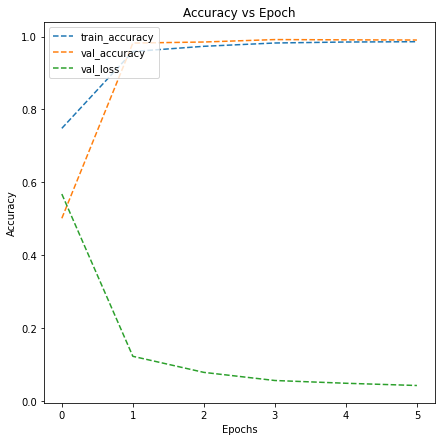

In [ ]:
plot_accuracy(history3)

In [ ]:
accuracy = model3.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

164/164 [==============================] - 1s 6ms/step - loss: 0.0243 - accuracy: 0.9914

 Test_Accuracy:- 0.9914007186889648


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2594
           1       0.99      0.99      0.99      2639

    accuracy                           0.99      5233
   macro avg       0.99      0.99      0.99      5233
weighted avg       0.99      0.99      0.99      5233



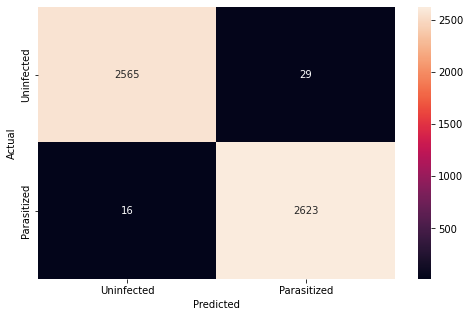

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model3.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights**

* The performance of the model increased substantially by making the modifications.  
* The model fit much more quickly, and is more computationally efficient. This is likely due to the use of ReLU as an activation function in deep layers.
* The use of binary crossentropy for a loss function is likely better than cross categorical as this is a binary 2 class output problem. 
* The overall accuracy of Model 3 improved to 99% versus 97% in Model 2, while the number of false negatives decreased, leading to an improvement in recall to 99% for parasitized images, while preserving the excellent recall for uninfected images at 99%. 
* One of the key parameters is to keep false negatives low and there are only 16 in the test data with this model.
* This is an outstanding high performing model. 

# **Model 4: Sigmoid activation on Output**
* Since this is a binary classification, use of this activation function for the final output layer may lead to better ultimate classification and recall.  Softmax is typically better used for multi-class models. 
* However due to exceptional performance of the model, we may not see any effect or a decrease in performance.  
* This is the only change in the model to isolate the effect of this change in parameters on the function of the model. 

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from keras.regularizers import l2
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Build model4 with increased dropout
def CNNbuild4(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.3))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5)) 
    model.add(Dense(classes, activation = 'sigmoid'))
    
    return model



In [ ]:
#instantiate the model
height = 64
width = 64
classes = 2
channels = 3
model4 = CNNbuild4(height = height, width = width, classes = classes, channels = channels)
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0

In [ ]:
#compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#using callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history4=model4.fit(x_train,y_train,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
524/524 [==============================] - 10s 16ms/step - loss: 0.6881 - accuracy: 0.6806 - val_loss: 4.2155 - val_accuracy: 0.5033
Epoch 2/20
524/524 [==============================] - 7s 14ms/step - loss: 0.2033 - accuracy: 0.9226 - val_loss: 0.1969 - val_accuracy: 0.9333
Epoch 3/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0904 - accuracy: 0.9695 - val_loss: 0.1513 - val_accuracy: 0.9589
Epoch 4/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0630 - accuracy: 0.9814 - val_loss: 0.1151 - val_accuracy: 0.9701
Epoch 5/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0573 - accuracy: 0.9821 - val_loss: 0.0704 - val_accuracy: 0.9790
Epoch 6/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0578 - accuracy: 0.9814 - val_loss: 0.0384 - val_accuracy: 0.9895
Epoch 7/20
524/524 [==============================] - 7s 13ms/step - loss: 0.0451 - accuracy: 0.9858 - val_loss: 0.0700 - val_accuracy: 0.978

####<B>Evaluating the Model 4

<b>Plot the train and validation accuracy

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history4):
    N = len(history4.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history4.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history4.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.plot(np.arange(0, N), history4.history["loss"], label="train_loss", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

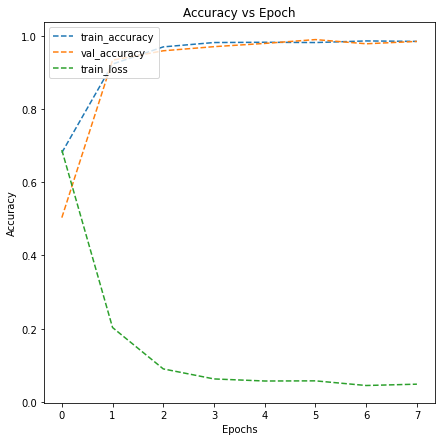

In [ ]:
# plotting the accuracies and loss
plot_accuracy(history4)

<B>Plotting the classification report and confusion matrix

In [ ]:
#test accuracy calculation
accuracy = model4.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

164/164 [==============================] - 1s 7ms/step - loss: 0.0426 - accuracy: 0.9876

 Test_Accuracy:- 0.987578809261322


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2607
           1       1.00      0.98      0.99      2626

    accuracy                           0.99      5233
   macro avg       0.99      0.99      0.99      5233
weighted avg       0.99      0.99      0.99      5233



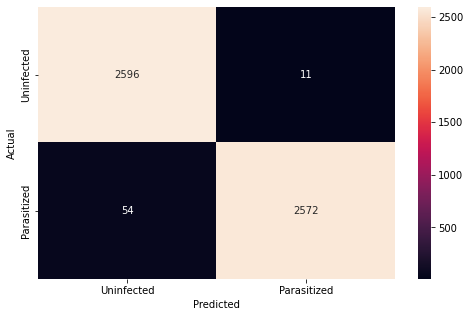

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model4.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Model 5 Observations & Insights:**

* The effect of a Sigmoid output activation function slightly decreased performance for precision in uninfected cells (98%) and recall(98%) for infected. 
* It increased performance slightly for recall for uninfected (100%) and precision for infected (100%).
Although it was stated that sigmoid may be better suited for binary classification it appears in this case softmax performs very well. 
* Overall this model still performed excellently with this activation function one of the most important performance indicators is the number of false negatives which we absolutely want to minimize.  This increased to 54 as reflected by a drop in recall for infected (99% down to 98%), this the best model appears to be Model 3. 

# **Model 5:  HSV Image Augmentation**

Early attempts with this model were unsuccessful and seemed to be hitting dead neurons, so the LeakyReLU activation function was employed along with a bit higher droput rate in both hidden and output layer as well as nudging up the batch size. 

### <b>Converting RGB to HSV of Images using OpenCV

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Converting the train data

In [ ]:
import cv2
gfx=[]   # to hold the HSV image array
for i in np.arange(0,20928,1):
  a=cv2.cvtColor(x_train[i],cv2.COLOR_BGR2HSV)
  gfx.append(a)
gfx=np.array(gfx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


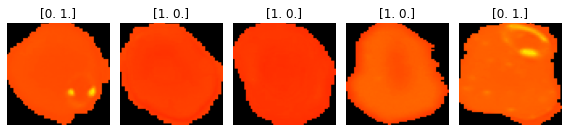

In [ ]:
viewimage=np.random.randint(1,20928,5)
fig,ax=plt.subplots(1,5,figsize=(8,8))
for t,i in zip(range(5),viewimage):
  Title=y_train[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

####<b> Converting the test data

In [ ]:
# Visualizing images in the test data

gfx2=[]   # to hold the HSV image array
for i in np.arange(0,5233,1):
  a=cv2.cvtColor(x_test[i],cv2.COLOR_BGR2HSV)
  gfx2.append(a)
gfx2=np.array(gfx2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


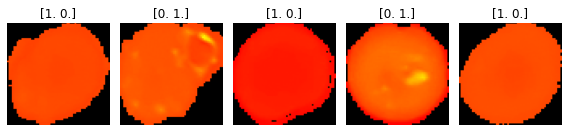

In [ ]:
viewimage=np.random.randint(1,5233,5)
fig,ax=plt.subplots(1,5,figsize=(8,8))
for t,i in zip(range(5),viewimage):
  Title=y_test[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx2[i])
  ax[t].set_axis_off()
  fig.tight_layout()

In [ ]:
print(f'SHAPE OF TRAINING HSV IMAGE DATA : {gfx.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {gfx2.shape}')

SHAPE OF TRAINING HSV IMAGE DATA : (20928, 64, 64, 3)
SHAPE OF TESTING IMAGE DATA : (5233, 64, 64, 3)


#####<b>Observations: 
We can see with the change to HSV the images show a contrast and the plasmodium shows up as light spots in the infected images.  

####<b>Building Model 5: HSV Augmentation w/ Model3 - best performer

In [ ]:
#instantiate the model 
height = 64
width = 64
classes = 2
channels = 3
model5 = CNNbuild3(height = height, width = width, classes = classes, channels = channels)
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0

In [ ]:
#compile the model

#tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name="SGD")
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#using callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history5=model5.fit(gfx,y_train,batch_size=40,callbacks=callbacks,validation_split=0.2,epochs=50,verbose=1)

Epoch 1/50
419/419 [==============================] - 8s 16ms/step - loss: 0.8216 - accuracy: 0.5852 - val_loss: 0.6598 - val_accuracy: 0.6316
Epoch 2/50
419/419 [==============================] - 6s 15ms/step - loss: 0.6844 - accuracy: 0.6385 - val_loss: 0.6466 - val_accuracy: 0.6323
Epoch 3/50
419/419 [==============================] - 6s 15ms/step - loss: 0.6459 - accuracy: 0.6447 - val_loss: 0.6246 - val_accuracy: 0.6519
Epoch 4/50
419/419 [==============================] - 6s 15ms/step - loss: 0.6354 - accuracy: 0.6466 - val_loss: 0.6804 - val_accuracy: 0.5958
Epoch 5/50
419/419 [==============================] - 6s 15ms/step - loss: 0.6208 - accuracy: 0.6595 - val_loss: 0.6187 - val_accuracy: 0.6605
Epoch 6/50
419/419 [==============================] - 6s 15ms/step - loss: 0.6161 - accuracy: 0.6637 - val_loss: 0.6315 - val_accuracy: 0.6400
Epoch 7/50
419/419 [==============================] - 6s 15ms/step - loss: 0.6136 - accuracy: 0.6660 - val_loss: 0.6294 - val_accuracy: 0.6562

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history5):
    N = len(history5.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history5.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history5.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

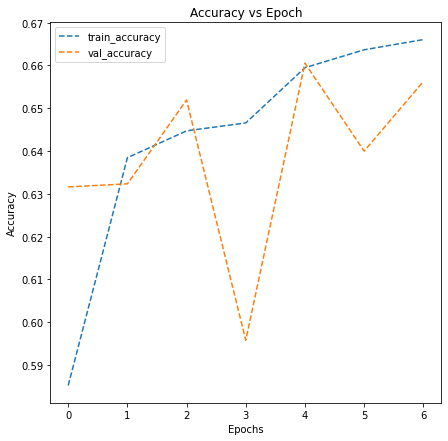

In [ ]:
# plotting the accuracies
plot_accuracy(history5)

<B>Plotting the classification report and confusion matrix

In [ ]:
#check accuracy against test data
accuracy = model5.evaluate(gfx2, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

164/164 [==============================] - 1s 7ms/step - loss: 0.6131 - accuracy: 0.6706

 Test_Accuracy:- 0.6705522537231445


              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2607
           1       0.67      0.67      0.67      2626

    accuracy                           0.67      5233
   macro avg       0.67      0.67      0.67      5233
weighted avg       0.67      0.67      0.67      5233



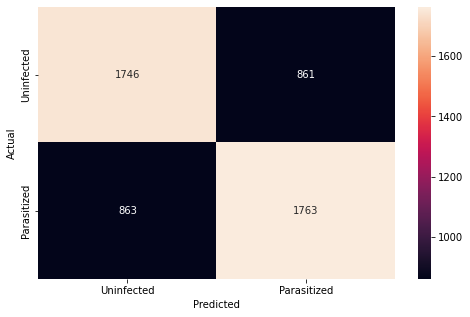

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model5.predict(gfx2)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

* It appears the model using the augmented HSV images may be overfitting as the training data performed better than the validation data.  
* We will repeat the model and increase the dropout since we are already utilizing batch normalization.  

# **Model 6: Data Augmentation with ImageDataGenerator**

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = False)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [ ]:
#calling the best performing CNN model
model6 = CNNbuild3(height = height, width = width, classes = classes, channels = channels)

In [ ]:
#compile the model
optim = tf.keras.optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model6.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [ ]:
#using callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history6 = model6.fit_generator(train_generator, steps_per_epoch = len(x_train) // 64, epochs = 20)

Epoch 1/20
327/327 [==============================] - 32s 93ms/step - loss: 0.8466 - accuracy: 0.5216
Epoch 2/20
327/327 [==============================] - 31s 94ms/step - loss: 0.6762 - accuracy: 0.6001
Epoch 3/20
327/327 [==============================] - 31s 94ms/step - loss: 0.6461 - accuracy: 0.6362
Epoch 4/20
327/327 [==============================] - 31s 94ms/step - loss: 0.6383 - accuracy: 0.6498
Epoch 5/20
327/327 [==============================] - 31s 93ms/step - loss: 0.5799 - accuracy: 0.7070
Epoch 6/20
327/327 [==============================] - 31s 94ms/step - loss: 0.3316 - accuracy: 0.8650
Epoch 7/20
327/327 [==============================] - 31s 94ms/step - loss: 0.2649 - accuracy: 0.8980
Epoch 8/20
327/327 [==============================] - 31s 93ms/step - loss: 0.2423 - accuracy: 0.9085
Epoch 9/20
327/327 [==============================] - 31s 94ms/step - loss: 0.2248 - accuracy: 0.9174
Epoch 10/20
327/327 [==============================] - 31s 94ms/step - loss: 0.216

In [ ]:
accuracy = model6.evaluate(val_generator, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 9ms/step - loss: 0.0461 - accuracy: 0.9903

 Test_Accuracy:- 0.9902541637420654


In [ ]:
predict = model6.evaluate_generator(val_generator, steps = 5)

In [ ]:
print(f'LOSS ON TEST DATA AFTER DATA AUGMENTATION : {predict[0]}')
print(f'ACCURACY ON TEST DATA AFTER DATA AUGMENTATION : {predict[1]}')

LOSS ON TEST DATA AFTER DATA AUGMENTATION : 0.03746264427900314
ACCURACY ON TEST DATA AFTER DATA AUGMENTATION : 0.9937499761581421


**Plotting the training and validation**

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history6):
    N = len(history6.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history6.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history6.history["loss"], label="train_loss", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

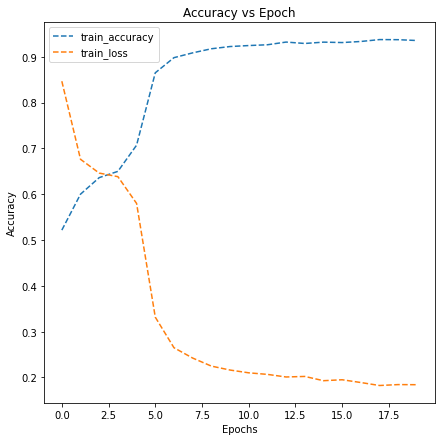

In [ ]:
# plotting the accuracies
plot_accuracy(history6)

**Plotting the confusion matrix and classification report**

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2607
           1       0.99      0.99      0.99      2626

    accuracy                           0.99      5233
   macro avg       0.99      0.99      0.99      5233
weighted avg       0.99      0.99      0.99      5233



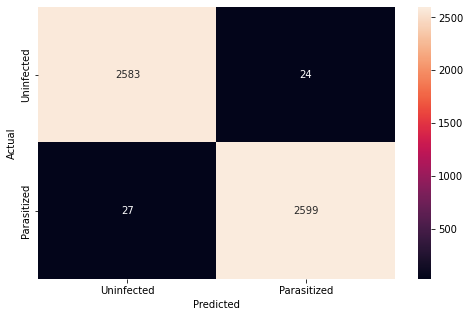

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model6.predict(val_generator)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

Data augmentation through ImageDataGenerator performed extremely well.  

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

# **Model 7: Pre-trained model (VGG16)**

In [78]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [79]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal, Constant



vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
chanDim = -1
if K.image_data_format() == 'channels_first':
        inputShape = (3, 64, 64)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [80]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
 

x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(512, activation='relu')(x)
x = BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
#x = BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9))(x)
#x - LayerNormalization ()(x)


# Similarly add a dense layer with 128 neurons


#x = LayerNormalization()(x)


# Add a dense layer with 64 neurons
x = BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9))(x)
#x = LayerNormalization()(x)
x = Dropout(0.2)(x)

pred = Dense(2, activation='softmax')(x)

model7 = Model(vgg.input, pred) #Initializing the model


####<b>Compiling the model

In [81]:
 #compile the model
#model7.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
optim = tf.keras.optimizers.Adam(lr = 0.0001)#, decay = 0.001 / 64)
model7.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['accuracy'])

<b> using callbacks

In [82]:
#using callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [83]:
#Fitting the model and running the model for 10 epochs
history7 = model7.fit(x_train, y_train, epochs=20, callbacks=callbacks, batch_size=16, validation_split=0.2, verbose=1)



Epoch 1/20
1047/1047 [==============================] - 13s 11ms/step - loss: 0.7252 - accuracy: 0.5984 - val_loss: 2.6386 - val_accuracy: 0.5215
Epoch 2/20
1047/1047 [==============================] - 11s 11ms/step - loss: 0.6359 - accuracy: 0.6745 - val_loss: 0.8162 - val_accuracy: 0.5530
Epoch 3/20
1047/1047 [==============================] - 11s 11ms/step - loss: 0.5815 - accuracy: 0.7146 - val_loss: 1.5279 - val_accuracy: 0.5258
Epoch 4/20
1047/1047 [==============================] - 11s 11ms/step - loss: 0.5536 - accuracy: 0.7357 - val_loss: 11.6687 - val_accuracy: 0.4785


<b>Plot the train and validation accuracy

In [84]:
# function to plot train and validation accuracy 
def plot_accuracy(history7):
    N = len(history7.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history7.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history7.history["val_accuracy"], label="VAl_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

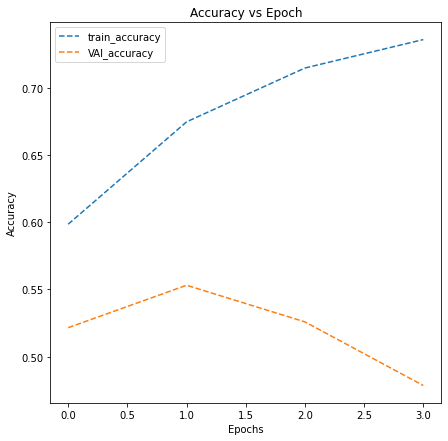

In [85]:
# plotting the accuracies
plot_accuracy(history7)

####<b> Evaluating the model

In [86]:
# Evaluating the model on test data
accuracy = model7.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

164/164 [==============================] - 2s 11ms/step - loss: 11.2714 - accuracy: 0.4986

 Test_Accuracy:- 0.49856677651405334


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2609
           1       0.00      0.00      0.00      2624

    accuracy                           0.50      5233
   macro avg       0.25      0.50      0.33      5233
weighted avg       0.25      0.50      0.33      5233



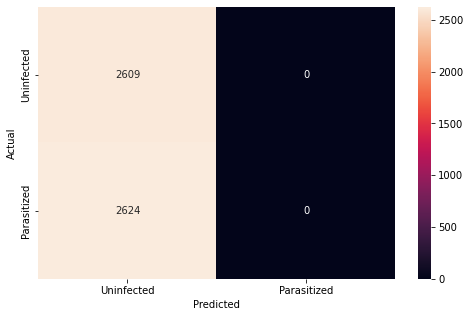

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model7.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Model 7 Observations and insights:**

* There was very poor performance and fit with VGG16.
* The model seemed to have a great deal of difficulty fitting the validation data.
* Many iterations of this model were attempted, including making the classification layer more complex and more simple.  
* All methods did not help with performance. 

### **Observations and Conclusions drawn from the final model (Model 3):** 
* Using correctly labeled data to train, validate and test a good performing CNN model is very important.
* Simple models seem to peform better.
* Model 3 had the following structure(613,186 Parameters):
  - 3 Convolutional layers with:
    - ReLU
    - MaxPooling
    - Batch Normalization
    - Dropout 0.2
  - Classification layer with:
    - One fully connected layer with 512 neurons
    - ReLU activation
    - Dropout 0.5
    - Softmax Activation Function on Final Output







**Improvements that can be done:**<br>


*  Since the model performed at 99% accuracy with very few false negatives the goal will be to simplify and reduce computing costs to deploy the model on a smartphone.
*  The following approach will be taken:
  - Reduce layers and overall number of parameters
  - Try to increase batch size and other factors to run the model quickly
* Good performance metrics will still be desired with simpler model:
  - 97% overall accuracy
  - Low false negatives and high recall (98%) for parasitized

**Refined insights**:
- More complex models don't always perform the best.
- Correctly labeled data help ensure good model development and performance on training, validation and test data.

**Comparison of various techniques and their relative performance**:
- The use of ReLU helps the model run quickly in deep layers
- During development sometimes learning may get stuck and LeakyReLU can help with this.
- Softmax performs just as well as Sigmoid for binary classification problems with CNN
- Batch size has implications for performance and how quickly a model can learn - there is a tradeoff.
- Dropout and Batch Normalization help prevent overfitting.
- Adding additional layers helps prevent underfitting.

**Proposal for the final solution design**:
- Model 3, a basic CNN with correctly labeled images and requires no augmentation was found to be the best model to use for further development and deployment. 
- Since the best performing model which used only original images of correctly labeled data was excellent, next steps will incude reduce the computing cost of the model, while mainting a high standard of accuracy, precison and recall. 